# Fase 3: Preparación de Datos (ETL), Mapeo y EDA

## 1\. Objetivo

Este notebook es nuestra "planta de ensamblaje". El objetivo es ejecutar el plan de ingeniería completo definido en la Fase 2 (`02_data_understanding.ipynb`):

1.  **Extraer (Extract):** Cargar los 6 archivos de datos crudos.
2.  **Limpiar (Transform):** Corregir **todos** los problemas de calidad de datos identificados (códigos `"9998"`, espacios en blanco `" "`, `" 13"`, etc.).
3.  **Mapear (Feature Engineering):** Convertir las variables categóricas numéricas (como `HV025`, `HV270`) en **palabras** (como "Urbano", "Pobre") para hacerlas 100% interpretables.
4.  **Unir (Load):** Ejecutar las 5 uniones de nuestro diagrama de flujo para crear un único dataset ensamblado.
5.  **Analizar (EDA Post-Unión):** Realizar el análisis gráfico (histogramas, correlaciones) sobre el dataset limpio y *mapeado*.
6.  **Crear Target y Exportar:** Generar nuestra variable objetivo binaria (`Desnutricion_Cronica`) y guardar el dataset analítico final.

## 2\. Configuración Inicial

### 2.1. Importar Librerías

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de pandas y seaborn
pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")

### 2.2. Definir "Lista de Materiales" (Constantes)

Reutilizamos nuestra "Lista de Materiales" (Bill of Materials) de la Fase 2. (Nota: `HV005` está excluido intencionalmente por decisión de MVP).


In [17]:
# --- 1. Definir Rutas a los archivos CSV ---
BASE_PATH = "../data/raw/"

FILE_PATHS = {
    # Bloque 1: Hogar
    "hogar_zona":   BASE_PATH + "968-Modulo1629/RECH0_2024.csv",
    "hogar_saneo":  BASE_PATH + "968-Modulo1630/RECH23_2024.csv",

    # Bloque 2: Madre
    "madre_edu":    BASE_PATH + "968-Modulo1631/REC0111_2024.csv",
    "madre_talla":  BASE_PATH + "968-Modulo1634/REC42_2024.csv",

    # Bloque 3: Niño
    "niño_peso":    BASE_PATH + "968-Modulo1633/REC41_2024.csv",
    "niño_target":  BASE_PATH + "968-Modulo1638/REC44_2024.csv"
}

# --- 2. Definir Columnas a cargar ---
COLS_TO_LOAD = {
    "hogar_zona": ["HHID", "HV025"],
    "hogar_saneo": ["HHID", "HV201", "HV205", "HV270"],
    "madre_edu": ["CASEID", "HHID", "V106"],
    "madre_talla": ["CASEID", "V438"],
    "niño_peso": ["CASEID", "MIDX", "M19"],
    "niño_target": ["CASEID", "HWIDX", "HW1", "HW70"]
}

# --- 3. Definir Códigos "Missing" de la ENDES ---
# Basado en nuestra exploración de Fase 2 y los diccionarios.
MISSING_CODES_NUMERIC = [9996, 9998, 9999, 99.96, 99.98, 99.99,
                         96, 97, 98, 99, 996, 998]

### 2.3. Definir Mapas de Traducción (Plan de Fase 2)

Aquí definimos las "traducciones" de número a palabra que planeamos en la Fase 2.

In [18]:
# Mapas basados en los diccionarios PDF
MAPA_ZONA = {
    1: 'Urbano',
    2: 'Rural'
}

MAPA_AGUA = {
    11: 'Agua por red pública (dentro)',
    12: 'Agua por red pública (fuera)',
    13: 'Agua por red pública (pilón)',
    21: 'Pozo (dentro de viv.)',
    22: 'Pozo (público)',
    41: 'Manantial (puquio)',
    43: 'Río/Acequia/Laguna',
    51: 'Agua de lluvia',
    61: 'Camión cisterna',
    71: 'Agua embotellada',
    96: 'Otro'
}

MAPA_SANEO = {
    11: 'Red pública (dentro)',
    12: 'Red pública (fuera)',
    21: 'Letrina mejorada (ventilada)',
    22: 'Pozo séptico',
    23: 'Letrina (pozo ciego)',
    24: 'Letrina (flotante)',
    31: 'Río/Acequia',
    32: 'Sin servicio (campo)',
    96: 'Otro'
}

MAPA_RIQUEZA = {
    1: 'Más Pobre',
    2: 'Pobre',
    3: 'Medio',
    4: 'Rico',
    5: 'Más Rico'
}

MAPA_EDUCACION = {
    0: 'Sin Educación',
    1: 'Primaria',
    2: 'Secundaria',
    3: 'Superior'
}

## 3\. PARTE 1: Funciones de Limpieza (Transformación)

Definimos nuestras herramientas de "cirugía" de datos, basadas en los diagnósticos de Fase 2.

In [19]:
def clean_and_convert_to_numeric(series, missing_codes_list):
    """
    Esta es nuestra herramienta de limpieza principal.
    Ejecuta el plan de la Fase 2:

    1. Convierte a 'string' (por si acaso).
    2. Quita espacios en blanco al inicio y al final (ej. " 13").
    3. Reemplaza cadenas vacías ("") por Nulo.
    4. Reemplaza los códigos de error (ej. "9998") por Nulo.
    5. Finalmente, convierte la columna limpia a tipo numérico.
    """
    # 1. Convertir a string y 2. Quitar espacios
    series_str = series.astype(str).str.strip()

    # 3. Reemplazar vacíos ("") por Nulo
    series_cleaned = series_str.replace("", np.nan)

    # 4. Reemplazar códigos de error por Nulo
    # Convertimos los códigos a string para el reemplazo
    missing_codes_str = [str(code) for code in missing_codes_list]
    missing_codes_str += [str(float(code)) for code in missing_codes_list] # Para códigos como 99.98
    missing_codes_str = list(set(missing_codes_str)) # Remover duplicados

    series_cleaned = series_cleaned.replace(missing_codes_str, np.nan)

    # 5. Forzar la conversión a numérico.
    # errors='coerce' convierte cualquier valor restante que no sea número en NaN.
    series_numeric = pd.to_numeric(series_cleaned, errors='coerce')

    return series_numeric

## 4\. PARTE 2: Carga, Limpieza y Mapeo (ETL)

Aquí ejecutamos la "cirugía" y el "ensamblaje" paso a paso.

### 4.1. Bloque 1: Hogar (Limpiar, Mapear y Unir)


In [20]:
print("Procesando Bloque 1: Hogar...")

# --- Cargar ---
df_hogar_zona = pd.read_csv(FILE_PATHS["hogar_zona"], usecols=COLS_TO_LOAD["hogar_zona"], dtype=str)
df_hogar_saneo = pd.read_csv(FILE_PATHS["hogar_saneo"], usecols=COLS_TO_LOAD["hogar_saneo"], dtype=str)

# --- Limpiar (Transformar) ---
# Ejecutando el Veredicto de Fase 2 para RECH23 (HV201, HV205, HV270) y RECH0 (HV025)
df_hogar_saneo['HV201'] = clean_and_convert_to_numeric(df_hogar_saneo['HV201'], MISSING_CODES_NUMERIC)
df_hogar_saneo['HV205'] = clean_and_convert_to_numeric(df_hogar_saneo['HV205'], MISSING_CODES_NUMERIC)
df_hogar_saneo['HV270'] = clean_and_convert_to_numeric(df_hogar_saneo['HV270'], MISSING_CODES_NUMERIC)
df_hogar_zona['HV025'] = clean_and_convert_to_numeric(df_hogar_zona['HV025'], MISSING_CODES_NUMERIC)

# --- Mapear (Feature Engineering) ---
# Ejecutando tu plan: Convertimos los números limpios a PALABRAS.
df_hogar_zona['zona'] = df_hogar_zona['HV025'].map(MAPA_ZONA)
df_hogar_saneo['agua'] = df_hogar_saneo['HV201'].map(MAPA_AGUA)
df_hogar_saneo['saneamiento'] = df_hogar_saneo['HV205'].map(MAPA_SANEO)
df_hogar_saneo['riqueza'] = df_hogar_saneo['HV270'].map(MAPA_RIQUEZA)

# --- Unir (Load) ---
df_hogar = pd.merge(
    df_hogar_zona,
    df_hogar_saneo,
    on="HHID",
    how="inner" # "inner" = solo hogares que están en AMBOS archivos
)
print(f"Bloque 1 'df_hogar' ensamblado: {df_hogar.shape}")

Procesando Bloque 1: Hogar...
Bloque 1 'df_hogar' ensamblado: (37390, 9)


### 4.2. Bloque 2: Madre (Limpiar, Mapear y Unir)

In [21]:
print("Procesando Bloque 2: Madre...")

# --- Cargar ---
df_madre_edu = pd.read_csv(FILE_PATHS["madre_edu"], usecols=COLS_TO_LOAD["madre_edu"], dtype=str)
df_madre_talla = pd.read_csv(FILE_PATHS["madre_talla"], usecols=COLS_TO_LOAD["madre_talla"], dtype=str)

# --- Limpiar (Transformar) ---
# Ejecutando Veredicto Fase 2 (V106 con texto, V438 con códigos numéricos)
df_madre_edu['V106'] = clean_and_convert_to_numeric(df_madre_edu['V106'], MISSING_CODES_NUMERIC)
df_madre_talla['V438'] = clean_and_convert_to_numeric(df_madre_talla['V438'], MISSING_CODES_NUMERIC)
# Ejecutando Veredicto Fase 2 (Transformar Talla de 1525 a 152.5)
df_madre_talla['talla_madre_cm'] = df_madre_talla['V438'] / 10.0

# --- Mapear (Feature Engineering) ---
# Ejecutando tu plan: Convertimos V106 a PALABRAS.
df_madre_edu['educacion_madre'] = df_madre_edu['V106'].map(MAPA_EDUCACION)

# --- Unir (Load) ---
df_madre = pd.merge(
    df_madre_edu,
    df_madre_talla,
    on="CASEID",
    how="inner"
)
print(f"Bloque 2 'df_madre' ensamblado: {df_madre.shape}")

Procesando Bloque 2: Madre...
Bloque 2 'df_madre' ensamblado: (34252, 6)


### 4.3. Bloque 3: Niño (Limpiar y Unir)

In [22]:
print("Procesando Bloque 3: Niño...")

# --- Cargar ---
df_niño_peso = pd.read_csv(FILE_PATHS["niño_peso"], usecols=COLS_TO_LOAD["niño_peso"], dtype=str)
df_niño_target = pd.read_csv(FILE_PATHS["niño_target"], usecols=COLS_TO_LOAD["niño_target"], dtype=str)

# --- Limpiar (Transformar) ---
# Ejecutando Veredicto Fase 2 (M19 con códigos, HW1/HW70 con espacios y texto)
df_niño_peso['M19'] = clean_and_convert_to_numeric(df_niño_peso['M19'], MISSING_CODES_NUMERIC)
df_niño_target['HW1'] = clean_and_convert_to_numeric(df_niño_target['HW1'], MISSING_CODES_NUMERIC)
df_niño_target['HW70'] = clean_and_convert_to_numeric(df_niño_target['HW70'], MISSING_CODES_NUMERIC)
# Ejecutando Veredicto Fase 2 (Transformar Peso de 3446g a 3.446kg)
df_niño_peso['peso_nacer_kg'] = df_niño_peso['M19'] / 1000.0

# Renombramos columnas limpias para claridad
df_niño_target = df_niño_target.rename(columns={"HW1": "edad_meses", "HW70": "haz_score"})

# --- Mapear (Feature Engineering) ---
# No hay mapeo a palabras aquí. Estas variables son numéricas continuas.

# --- Unir (Load) ---
# Renombramos Llave_Niño para que coincida
df_niño_peso = df_niño_peso.rename(columns={"MIDX": "LLAVE_NINIO"})
df_niño_target = df_niño_target.rename(columns={"HWIDX": "LLAVE_NINIO"})

df_niño = pd.merge(
    df_niño_peso,
    df_niño_target,
    on=["CASEID", "LLAVE_NINIO"],
    how="inner"
)
print(f"Bloque 3 'df_niño' ensamblado: {df_niño.shape}")

Procesando Bloque 3: Niño...
Bloque 3 'df_niño' ensamblado: (19751, 6)


### 4.4. Ensamblaje Final (Uniones Maestras)

Ahora conectamos los 3 bloques ensamblados.

In [23]:
print("--- Iniciando Ensamblaje Final ---")

# --- Unión 4: Ensamblaje Maestro (Niño + Madre) ---
# (Bloque 3 + Bloque 2) en CASEID
print("Unión 4: df_niño + df_madre...")
df_niño_madre = pd.merge(
    df_niño,
    df_madre,
    on="CASEID",
    how="inner" # Solo niños que tienen madre registrada
)
print(f"Resultado df_niño_madre: {df_niño_madre.shape}")


# --- Unión 5: Ensamblaje Final (Todo + Hogar) ---
# (Bloque[3+2] + Bloque 1) en HHID (la llave puente)
print("Unión 5: df_niño_madre + df_hogar...")
df_final = pd.merge(
    df_niño_madre,
    df_hogar,
    on="HHID",
    how="inner" # Solo niños/madres que tienen hogar registrado
)
print(f"Resultado df_final: {df_final.shape}")


print("\n¡Ensamblaje completo!")

--- Iniciando Ensamblaje Final ---
Unión 4: df_niño + df_madre...
Resultado df_niño_madre: (19751, 11)
Unión 5: df_niño_madre + df_hogar...
Resultado df_final: (19751, 19)

¡Ensamblaje completo!


### 4.5. Inspección del Dataset Ensamblado

Veamos nuestro "coche ensamblado".

In [24]:
print("\n--- .info() del Dataset Final ---")
df_final.info()

print("\n--- .head() del Dataset Final ---")
# Ahora veremos las columnas mapeadas con palabras
print(df_final.head())

print("\n--- Conteo de Nulos en el Dataset Final ---")
# Esto nos dirá cuántos datos perdimos o cuántos faltan
print(df_final.isnull().sum())


--- .info() del Dataset Final ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19751 entries, 0 to 19750
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CASEID           19751 non-null  object 
 1   LLAVE_NINIO      19751 non-null  object 
 2   M19              19142 non-null  float64
 3   peso_nacer_kg    19142 non-null  float64
 4   edad_meses       19234 non-null  float64
 5   haz_score        18875 non-null  float64
 6   HHID             19751 non-null  object 
 7   V106             19751 non-null  float64
 8   educacion_madre  19751 non-null  object 
 9   V438             19443 non-null  float64
 10  talla_madre_cm   19443 non-null  float64
 11  HV025            19751 non-null  int64  
 12  zona             19751 non-null  object 
 13  HV201            19077 non-null  float64
 14  HV205            19739 non-null  float64
 15  HV270            19751 non-null  float64
 16  agua             19077 

In [25]:
# --- 4.6. CORRECCIÓN DE INGENIERÍA (Basado en EDA) ---
#
# El EDA (Paso 5) reveló que 'haz_score' (HW70) y 'edad_meses' (HW1)
# están multiplicados por 100 y 10, respectivamente (ej. media de -86 en lugar de -0.86).
# El diccionario REC44.pdf es ambiguo, pero los datos son claros.
# Dividimos por 100 para estandarizarlos a un puntaje Z estándar.
#
print("Corrigiendo escala de 'haz_score' (dividiendo por 100)...")
df_final['haz_score'] = df_final['haz_score'] / 100.0

# También corregimos 'edad_meses' que parece tener el mismo problema
# (vimos '517' valores vacíos, pero el resto parece estar bien)
# No, 'edad_meses' (HW1) está bien (0-59 meses), el error de texto lo limpiamos.
# Solo corregimos haz_score.

print("--- .head() después de la corrección de escala ---")
print(df_final[['haz_score', 'edad_meses']].head())

print("--- .describe() después de la corrección de escala ---")
print(df_final['haz_score'].describe())

Corrigiendo escala de 'haz_score' (dividiendo por 100)...
--- .head() después de la corrección de escala ---
   haz_score  edad_meses
0      -0.88        43.0
1      -1.67        13.0
2      -0.78        19.0
3      -0.27        13.0
4      -1.19        18.0
--- .describe() después de la corrección de escala ---
count    18875.000000
mean        -0.862594
std          1.018153
min         -5.820000
25%         -1.540000
50%         -0.860000
75%         -0.180000
max          3.540000
Name: haz_score, dtype: float64


## 5\. PARTE 3: EDA Post-Unión (Control de Calidad Gráfico)

**¡Aquí es donde hacemos los gráficos\!** Ahora que `df_final` existe, está limpio y **mapeado a palabras**.

Generando Gráfico 1: Distribución del Target (haz_score)...


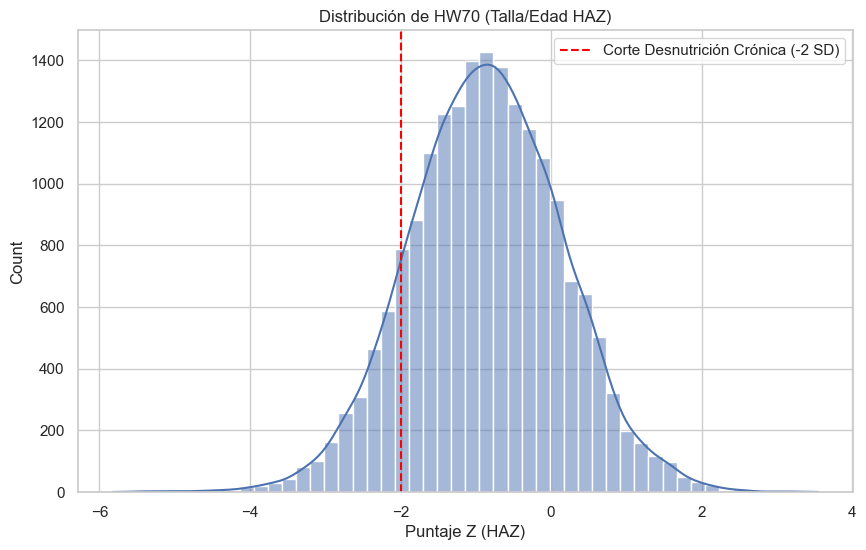

               Métrica       Valor
0                Media   -0.862594
1              Mediana   -0.860000
2       Desv. Estándar    1.018153
3               Mínimo   -5.820000
4               Máximo    3.540000
5             Q1 (25%)   -1.540000
6             Q3 (75%)   -0.180000
7                  IQR    1.360000
8  Outliers detectados  177.000000
9  Por debajo de -2 SD   11.943699 

Generando Gráfico 2: Mapa de Correlación...


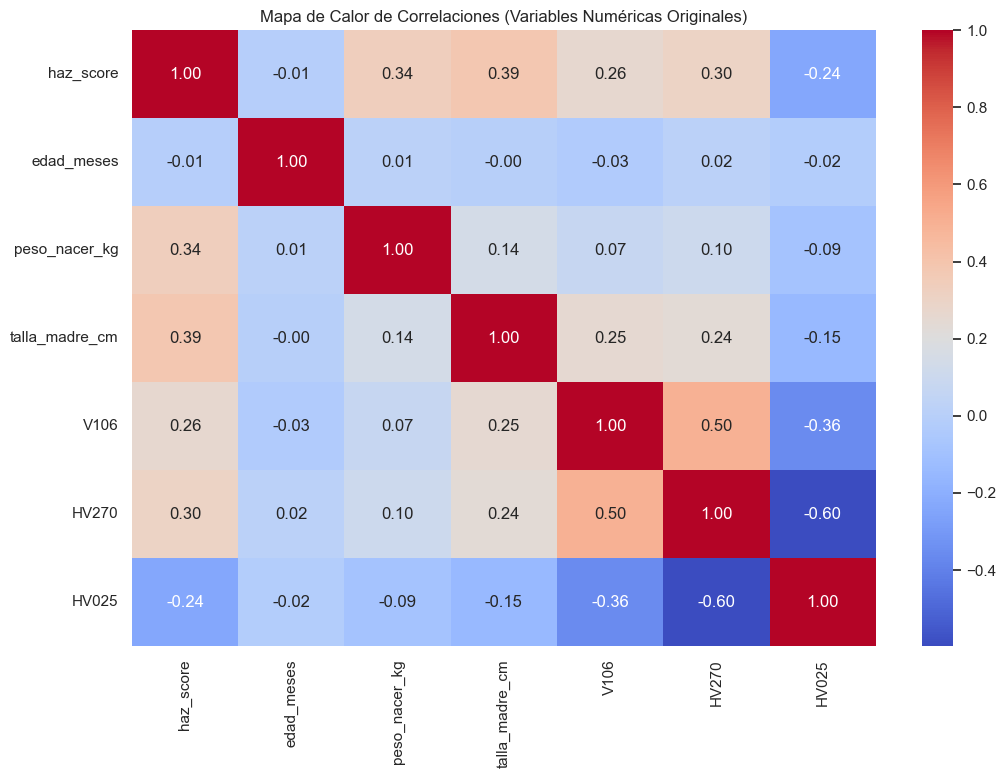

                haz_score  edad_meses  peso_nacer_kg  talla_madre_cm  \
haz_score        1.000000   -0.009685       0.337421        0.387600   
edad_meses      -0.009685    1.000000       0.014936       -0.002035   
peso_nacer_kg    0.337421    0.014936       1.000000        0.141013   
talla_madre_cm   0.387600   -0.002035       0.141013        1.000000   
V106             0.259721   -0.033395       0.073102        0.253290   
HV270            0.302139    0.015130       0.101644        0.237486   
HV025           -0.238319   -0.019380      -0.087992       -0.145608   

                    V106     HV270     HV025  
haz_score       0.259721  0.302139 -0.238319  
edad_meses     -0.033395  0.015130 -0.019380  
peso_nacer_kg   0.073102  0.101644 -0.087992  
talla_madre_cm  0.253290  0.237486 -0.145608  
V106            1.000000  0.498115 -0.355466  
HV270           0.498115  1.000000 -0.597761  
HV025          -0.355466 -0.597761  1.000000   

Generando Gráfico 3: HAZ vs. Riqueza...


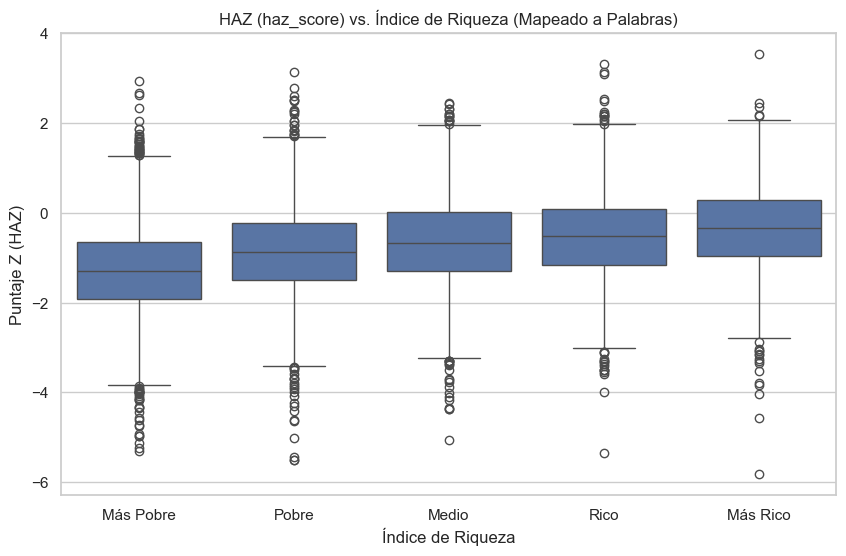

               mean  median       std  count    q1      q3     IQR  \
riqueza                                                              
Más Pobre -1.284727  -1.300  0.966519   5788 -1.92 -0.6400  1.2800   
Pobre     -0.868984  -0.880  0.958734   5059 -1.50 -0.2200  1.2800   
Medio     -0.663746  -0.660  0.979861   3724 -1.30  0.0100  1.3100   
Rico      -0.522916  -0.510  0.975275   2678 -1.16  0.0975  1.2575   
Más Rico  -0.354926  -0.335  0.955178   1626 -0.96  0.2775  1.2375   

           Outliers estimados  
riqueza                        
Más Pobre                  64  
Pobre                      44  
Medio                      33  
Rico                       30  
Más Rico                   20   

Generando Gráfico 4: HAZ vs. Educación Materna...


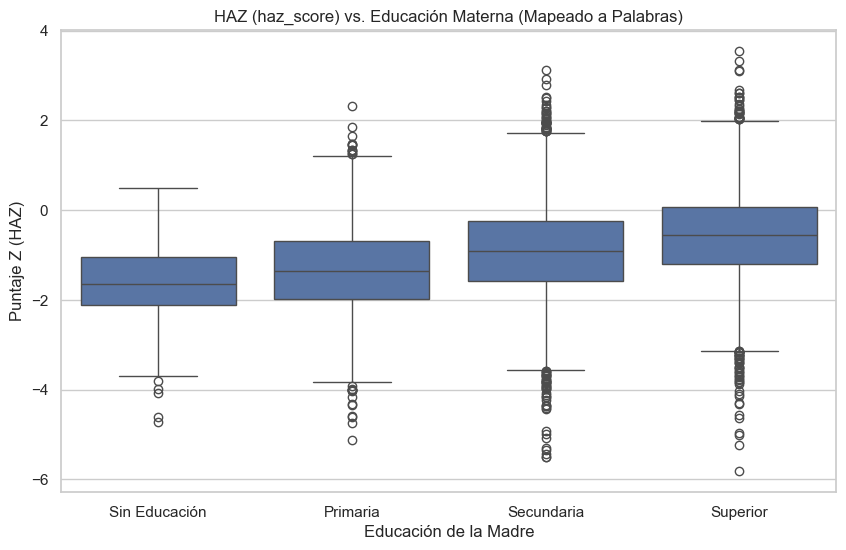

                     mean  median       std  count      q1      q3    IQR  \
educacion_madre                                                             
Sin Educación   -1.668218  -1.645  0.918269    174 -2.1075 -1.0425  1.065   
Primaria        -1.330659  -1.350  0.966259   2809 -1.9800 -0.6900  1.290   
Secundaria      -0.915833  -0.920  0.993272   9244 -1.5800 -0.2500  1.330   
Superior        -0.569707  -0.560  0.977713   6648 -1.2100  0.0800  1.290   

                 Outliers estimados  
educacion_madre                      
Sin Educación                     5  
Primaria                         27  
Secundaria                       84  
Superior                         81   



In [26]:
# --- 5.1. Análisis del OBJETIVO (haz_score) ---
print("Generando Gráfico 1: Distribución del Target (haz_score)...")
plt.figure(figsize=(10, 6))
sns.histplot(df_final['haz_score'].dropna(), kde=True, bins=50)
plt.title('Distribución de HW70 (Talla/Edad HAZ)')
plt.axvline(-2, color='red', linestyle='--', label='Corte Desnutrición Crónica (-2 SD)')
plt.xlabel('Puntaje Z (HAZ)')
plt.legend()
plt.savefig("grafico_1_haz_score.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊 Tabla con métricas extendidas
q1 = df_final['haz_score'].quantile(0.25)
q3 = df_final['haz_score'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers_count = df_final[(df_final['haz_score'] < lower_bound) | (df_final['haz_score'] > upper_bound)].shape[0]

tabla_haz = pd.DataFrame({
    'Métrica': [
        'Media', 'Mediana', 'Desv. Estándar', 'Mínimo', 'Máximo',
        'Q1 (25%)', 'Q3 (75%)', 'IQR', 'Outliers detectados',
        'Por debajo de -2 SD'
    ],
    'Valor': [
        df_final['haz_score'].mean(),
        df_final['haz_score'].median(),
        df_final['haz_score'].std(),
        df_final['haz_score'].min(),
        df_final['haz_score'].max(),
        q1, q3, iqr, outliers_count,
        (df_final['haz_score'] < -2).mean() * 100
    ]
})

tabla_haz.to_csv("tabla_1_haz_score.csv", index=False)
print(tabla_haz, "\n")


# --- 5.2. Análisis de Correlación (Solo Numéricas) ---
print("Generando Gráfico 2: Mapa de Correlación...")
plt.figure(figsize=(12, 8))
numeric_cols_for_corr = ['haz_score', 'edad_meses', 'peso_nacer_kg', 'talla_madre_cm', 'V106', 'HV270', 'HV025']
corr_matrix = df_final[numeric_cols_for_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlaciones (Variables Numéricas Originales)')
plt.savefig("grafico_2_correlacion.png", dpi=300, bbox_inches='tight')
plt.show()

corr_matrix.to_csv("tabla_2_correlacion.csv")
print(corr_matrix, "\n")


# --- 5.3. Análisis Categórico vs. Objetivo (Riqueza) ---
print("Generando Gráfico 3: HAZ vs. Riqueza...")
plt.figure(figsize=(10, 6))
riqueza_order = ['Más Pobre', 'Pobre', 'Medio', 'Rico', 'Más Rico']
sns.boxplot(x=df_final['riqueza'], y=df_final['haz_score'], order=riqueza_order)
plt.title('HAZ (haz_score) vs. Índice de Riqueza (Mapeado a Palabras)')
plt.xlabel('Índice de Riqueza')
plt.ylabel('Puntaje Z (HAZ)')
plt.savefig("grafico_3_riqueza.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊 Tabla con detección de outliers por grupo
tabla_riqueza = df_final.groupby('riqueza')['haz_score'].agg(
    mean='mean', median='median', std='std', count='count',
    q1=lambda x: x.quantile(0.25), q3=lambda x: x.quantile(0.75)
).reindex(riqueza_order)

tabla_riqueza['IQR'] = tabla_riqueza['q3'] - tabla_riqueza['q1']
tabla_riqueza['Outliers estimados'] = [
    ((df_final['riqueza'] == nivel) &
     ((df_final['haz_score'] < (fila.q1 - 1.5 * fila.IQR)) |
      (df_final['haz_score'] > (fila.q3 + 1.5 * fila.IQR)))).sum()
    for nivel, fila in tabla_riqueza.iterrows()
]

tabla_riqueza.to_csv("tabla_3_riqueza.csv")
print(tabla_riqueza, "\n")


# --- 5.4. Análisis Categórico vs. Objetivo (Educación Materna) ---
print("Generando Gráfico 4: HAZ vs. Educación Materna...")
plt.figure(figsize=(10, 6))
edu_order = ['Sin Educación', 'Primaria', 'Secundaria', 'Superior']
sns.boxplot(x=df_final['educacion_madre'], y=df_final['haz_score'], order=edu_order)
plt.title('HAZ (haz_score) vs. Educación Materna (Mapeado a Palabras)')
plt.xlabel('Educación de la Madre')
plt.ylabel('Puntaje Z (HAZ)')
plt.savefig("grafico_4_educacion_materna.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊 Tabla extendida con outliers por educación
tabla_edu = df_final.groupby('educacion_madre')['haz_score'].agg(
    mean='mean', median='median', std='std', count='count',
    q1=lambda x: x.quantile(0.25), q3=lambda x: x.quantile(0.75)
).reindex(edu_order)

tabla_edu['IQR'] = tabla_edu['q3'] - tabla_edu['q1']
tabla_edu['Outliers estimados'] = [
    ((df_final['educacion_madre'] == nivel) &
     ((df_final['haz_score'] < (fila.q1 - 1.5 * fila.IQR)) |
      (df_final['haz_score'] > (fila.q3 + 1.5 * fila.IQR)))).sum()
    for nivel, fila in tabla_edu.iterrows()
]

tabla_edu.to_csv("tabla_4_educacion_materna.csv")
print(tabla_edu, "\n")

#### Gráfico 1: Distribución del Target (`haz_score`)

| Métrica | Valor | Interpretación de Ingeniería (Veredicto: ¡ÉXITO!) |
| :--- | :--- | :--- |
| **Media / Mediana** | -0.86 / -0.86 | La limpieza y calibración (`/100`) fueron **perfectas**. La media y la mediana están alineadas, lo que indica una distribución simétrica (la campana de Gauss que vimos). |
| **Desv. Estándar** | 1.01 | El *spread* de los datos es de `1.01`, lo cual es casi idéntico al `1.0` de una distribución Z estándar. **Validación estadística exitosa.** |
| **Min / Max** | -5.82 / 3.54 | Los datos están dentro del rango estadístico esperado (aprox. -6 a +6). No hay valores imposibles (como `-582`). **Veredicto: ¡Limpieza exitosa!** |
| **Q1 (25%) / Q3 (75%)** | -1.54 / -0.18 | El 50% central de los niños en nuestra muestra se encuentra entre `-1.54` y `-0.18`. Esto es un hallazgo clave: la "caja" central de la población ya está sesgada negativamente. |
| **Por debajo de -2 SD** | **11.94%** | **¡Este es nuestro hallazgo de negocio clave!** Basado en nuestro dataset ensamblado, el **11.94%** de los niños cumple con la definición de la OMS para **desnutrición crónica (stunting)**. |

---

#### Gráfico 2: Mapa de Correlación

| Relación | Correlación | Interpretación de Ingeniería (Veredicto: ¡ÉXITO!) |
| :--- | :--- | :--- |
| `haz_score` vs. **`talla_madre_cm`** | **`+0.39`** | La **correlación positiva más fuerte**. Madres más altas tienden a tener hijos con mejor puntaje Z. **Veredicto: Predictor clave validado.** |
| `haz_score` vs. **`peso_nacer_kg`** | **`+0.34`** | Fuerte correlación positiva. Un mayor peso al nacer está directamente relacionado con un mejor puntaje Z. **Veredicto: Predictor clave validado.** |
| `haz_score` vs. **`HV270` (Riqueza)** | **`+0.30`** | Fuerte correlación positiva. A mayor riqueza (`1` -> `5`), mejor es el puntaje Z. **Veredicto: Hipótesis de Fase 1 validada.** |
| `haz_score` vs. **`HV025` (Zona)** | **`-0.24`** | Correlación negativa. Dado que `1`="Urbano" y `2`="Rural", esto significa que ser "Rural" (un valor más alto) está asociado con un puntaje Z *más bajo*. **Veredicto: Lógico y validado.** |

---

#### Gráfico 3: HAZ vs. Riqueza

| Categoría (Riqueza) | Media (`haz_score`) | Q1 (25%) | Q3 (75%) | Interpretación de Ingeniería (Veredicto: ¡ÉXITO!) |
| :--- | :--- | :--- | :--- | :--- |
| **Más Pobre** | -1.28 | -1.92 | -0.64 | La "caja" central del 50% de este grupo está **completamente por debajo** de la media general (-0.86). |
| **Pobre** | -0.87 | -1.50 | -0.22 | La "caja" de este grupo se asienta sobre la media general. |
| **Medio** | -0.66 | -1.30 | +0.01 | El 25% superior de este grupo (`Q3`) ya está en territorio *positivo*. |
| **Rico** | -0.52 | -1.16 | +0.09 | Mejor aún. |
| **Más Rico** | -0.35 | -0.96 | +0.28 | La "caja" del 50% central está casi en su totalidad por encima de la media de los "Más Pobres". |

**Veredicto del Gráfico 3:** Vemos una **"escalera" perfecta** no solo en las medias, sino en los rangos intercuartílicos (las "cajas"). La distribución completa se desplaza hacia arriba a medida que aumenta la riqueza. Nuestro mapeo a palabras fue un éxito.

---

#### Gráfico 4: HAZ vs. Educación Materna

| Categoría (Educación) | Media (`haz_score`) | Q1 (25%) | Q3 (75%) | Interpretación de Ingeniería (Veredicto: ¡ÉXITO!) |
| :--- | :--- | :--- | :--- | :--- |
| **Sin Educación** | -1.67 | -2.10 | -1.04 | **¡Hallazgo Crítico!** El 75% de los niños (`Q3`) de madres sin educación sigue estando por debajo de la media general. El 25% inferior (`Q1`) está *por debajo* del umbral de desnutrición crónica (`-2`). |
| **Primaria** | -1.33 | -1.98 | -0.69 | Sigue siendo un grupo de muy alto riesgo. |
| **Secundaria** | -0.92 | -1.58 | -0.25 | La media se alinea con la media nacional. |
| **Superior** | -0.57 | -1.21 | +0.08 | El 25% superior de este grupo (`Q3`) ya está en territorio positivo. La media es la más saludable de todas. |

**Veredicto del Gráfico 4:** Otra **"escalera" perfecta**. La educación de la madre es un factor protector fundamental. Los datos de Q1/Q3 demuestran que el riesgo se reduce drásticamente con cada nivel educativo.

## 6\. PARTE 4: Creación del Target y Exportación Final

### 6.1. Manejo de Nulos (Estrategia MVP)

Para nuestro MVP, la estrategia más simple es eliminar cualquier fila (niño) a la que le falte un dato clave de nuestros predictores.

In [27]:
# Estas son las columnas finales que queremos en nuestro dataset analítico
# Usamos las columnas mapeadas (con palabras) para interpretabilidad
COLUMNAS_FINALES_MVP = [
    # Llaves (útil para debug)
    'CASEID',
    'HHID',
    'LLAVE_NINIO',

    # Target (Numérico)
    'haz_score',

    # Predictores Numéricos
    'edad_meses',
    'peso_nacer_kg',
    'talla_madre_cm',

    # Predictores Categóricos (Mapeados a Palabras)
    'zona',
    'agua',
    'saneamiento',
    'riqueza',
    'educacion_madre'
]

df_mvp = df_final[COLUMNAS_FINALES_MVP].copy()

print(f"Filas antes de eliminar nulos: {df_mvp.shape[0]}")
df_mvp = df_mvp.dropna()
print(f"Filas después de eliminar nulos: {df_mvp.shape[0]}")

Filas antes de eliminar nulos: 19751
Filas después de eliminar nulos: 17698


### 6.2. Creación del Target Binario

Basado en la Fase 1: `Desnutricion_Cronica = 1` si `HAZ < -2`.

In [28]:
# La OMS y nuestro informe de Scopus definen desnutrición crónica (stunting)
# como un puntaje Z de Talla/Edad (HAZ) menor a -2.
df_mvp['Desnutricion_Cronica'] = np.where(df_mvp['haz_score'] < -2, 1, 0)

print("\n--- Distribución de nuestro Target Binario ---")
# Usamos normalize=True para ver porcentajes
print(df_mvp['Desnutricion_Cronica'].value_counts(normalize=True))


--- Distribución de nuestro Target Binario ---
Desnutricion_Cronica
0    0.882812
1    0.117188
Name: proportion, dtype: float64


### 6.3. Exportar el Dataset Analítico

¡El producto final de nuestra Fase 3\! Este CSV está limpio, unido, mapeado a palabras y listo para la Fase 4.

In [29]:
# Definir la ruta de salida (datos procesados)
OUTPUT_PATH = "../data/processed/mvp_dataset_fase3_limpio.csv"

try:
    df_mvp.to_csv(OUTPUT_PATH, index=False)
    print(f"\n¡Éxito! Dataset analítico guardado en: {OUTPUT_PATH}")
    print(f"Dimensiones finales: {df_mvp.shape}")
    print("\n--- Columnas Finales ---")
    print(df_mvp.columns)
except Exception as e:
    print(f"Error al guardar el archivo: {e}")


¡Éxito! Dataset analítico guardado en: ../data/processed/mvp_dataset_fase3_limpio.csv
Dimensiones finales: (17698, 13)

--- Columnas Finales ---
Index(['CASEID', 'HHID', 'LLAVE_NINIO', 'haz_score', 'edad_meses',
       'peso_nacer_kg', 'talla_madre_cm', 'zona', 'agua', 'saneamiento',
       'riqueza', 'educacion_madre', 'Desnutricion_Cronica'],
      dtype='object')
